In [1]:
import scanpy as sc
from torch.utils.data import Dataset, DataLoader
import torch
from flecs.utils import set_seed
from tqdm import tqdm
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import os
from flecs.utils import get_project_root
from flecs.sc.model import GRNCellPop
from flecs.sc.utils import get_cell_indices

scv.set_figure_params('scvelo')  # for beautified visualization
plt.rcParams["figure.figsize"] = (16,8)

## Load data

In [2]:
set_seed(0)
adata = sc.read_h5ad(os.path.join(get_project_root(),
                                  "datasets", "Paul15", "processed", "adata_processed_with_paths_magic.h5ad")
                     )

In [3]:
len(adata)

7296

In [4]:
# Get cell indices coming from the different batches
cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells = get_cell_indices(adata)
cebpa_ko_adata = adata[cmp_cells + cebpa_cells]

## Model

In [5]:
batch_size = cebpa_ko_adata.shape[0] // 2

In [6]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=50, use_2nd_order_interactions=False)

## Load weights

In [7]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "logs", "trained_mycellpop_nov_3_7.pt"), 
                                map_location=torch.device('cpu'))

In [8]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

In [9]:
trained_state_dict.pop("alpha", None)
trained_state_dict.pop("bias", None)
trained_state_dict.pop("simple_conv_weights", None)

tensor([[[-0.0411],
         [-0.0411],
         [-0.0322],
         ...,
         [-0.0332],
         [-0.0065],
         [-0.0533]]])

In [10]:
mycellpop.interventional_model.load_state_dict(trained_state_dict)

<All keys matched successfully>

In [11]:
mycellpop.intervene("cebpa")

## Plotting

In [12]:
sc.pp.neighbors(cebpa_ko_adata, n_neighbors=30, n_pcs=50)
highly_var_gene_list = list(adata.var.iloc[np.where(adata.X.std(axis=0) > 5)[0]].index)

In [13]:
with torch.no_grad():
    
    velocities = []
    
    for i in tqdm(range(cebpa_ko_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(cebpa_ko_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        
#         gene_expr = torch.cat((gene_expr, gene_expr, gene_expr), dim=2)
        velocity = mycellpop.get_derivatives(torch.cat((gene_expr, torch.zeros(batch_size, 50, 1)), dim=1))
        
        velocities.append(velocity[:, :-50])
        
velocities = torch.cat(velocities).cpu().numpy()[:, :, 0]
cebpa_ko_adata.layers["velocity"] = velocities
cebpa_ko_adata.layers["X"] = cebpa_ko_adata.X

100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:43<00:00, 21.54s/it]


In [14]:
scv.tl.velocity_graph(cebpa_ko_adata, xkey="X", gene_subset=highly_var_gene_list, n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/3456 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


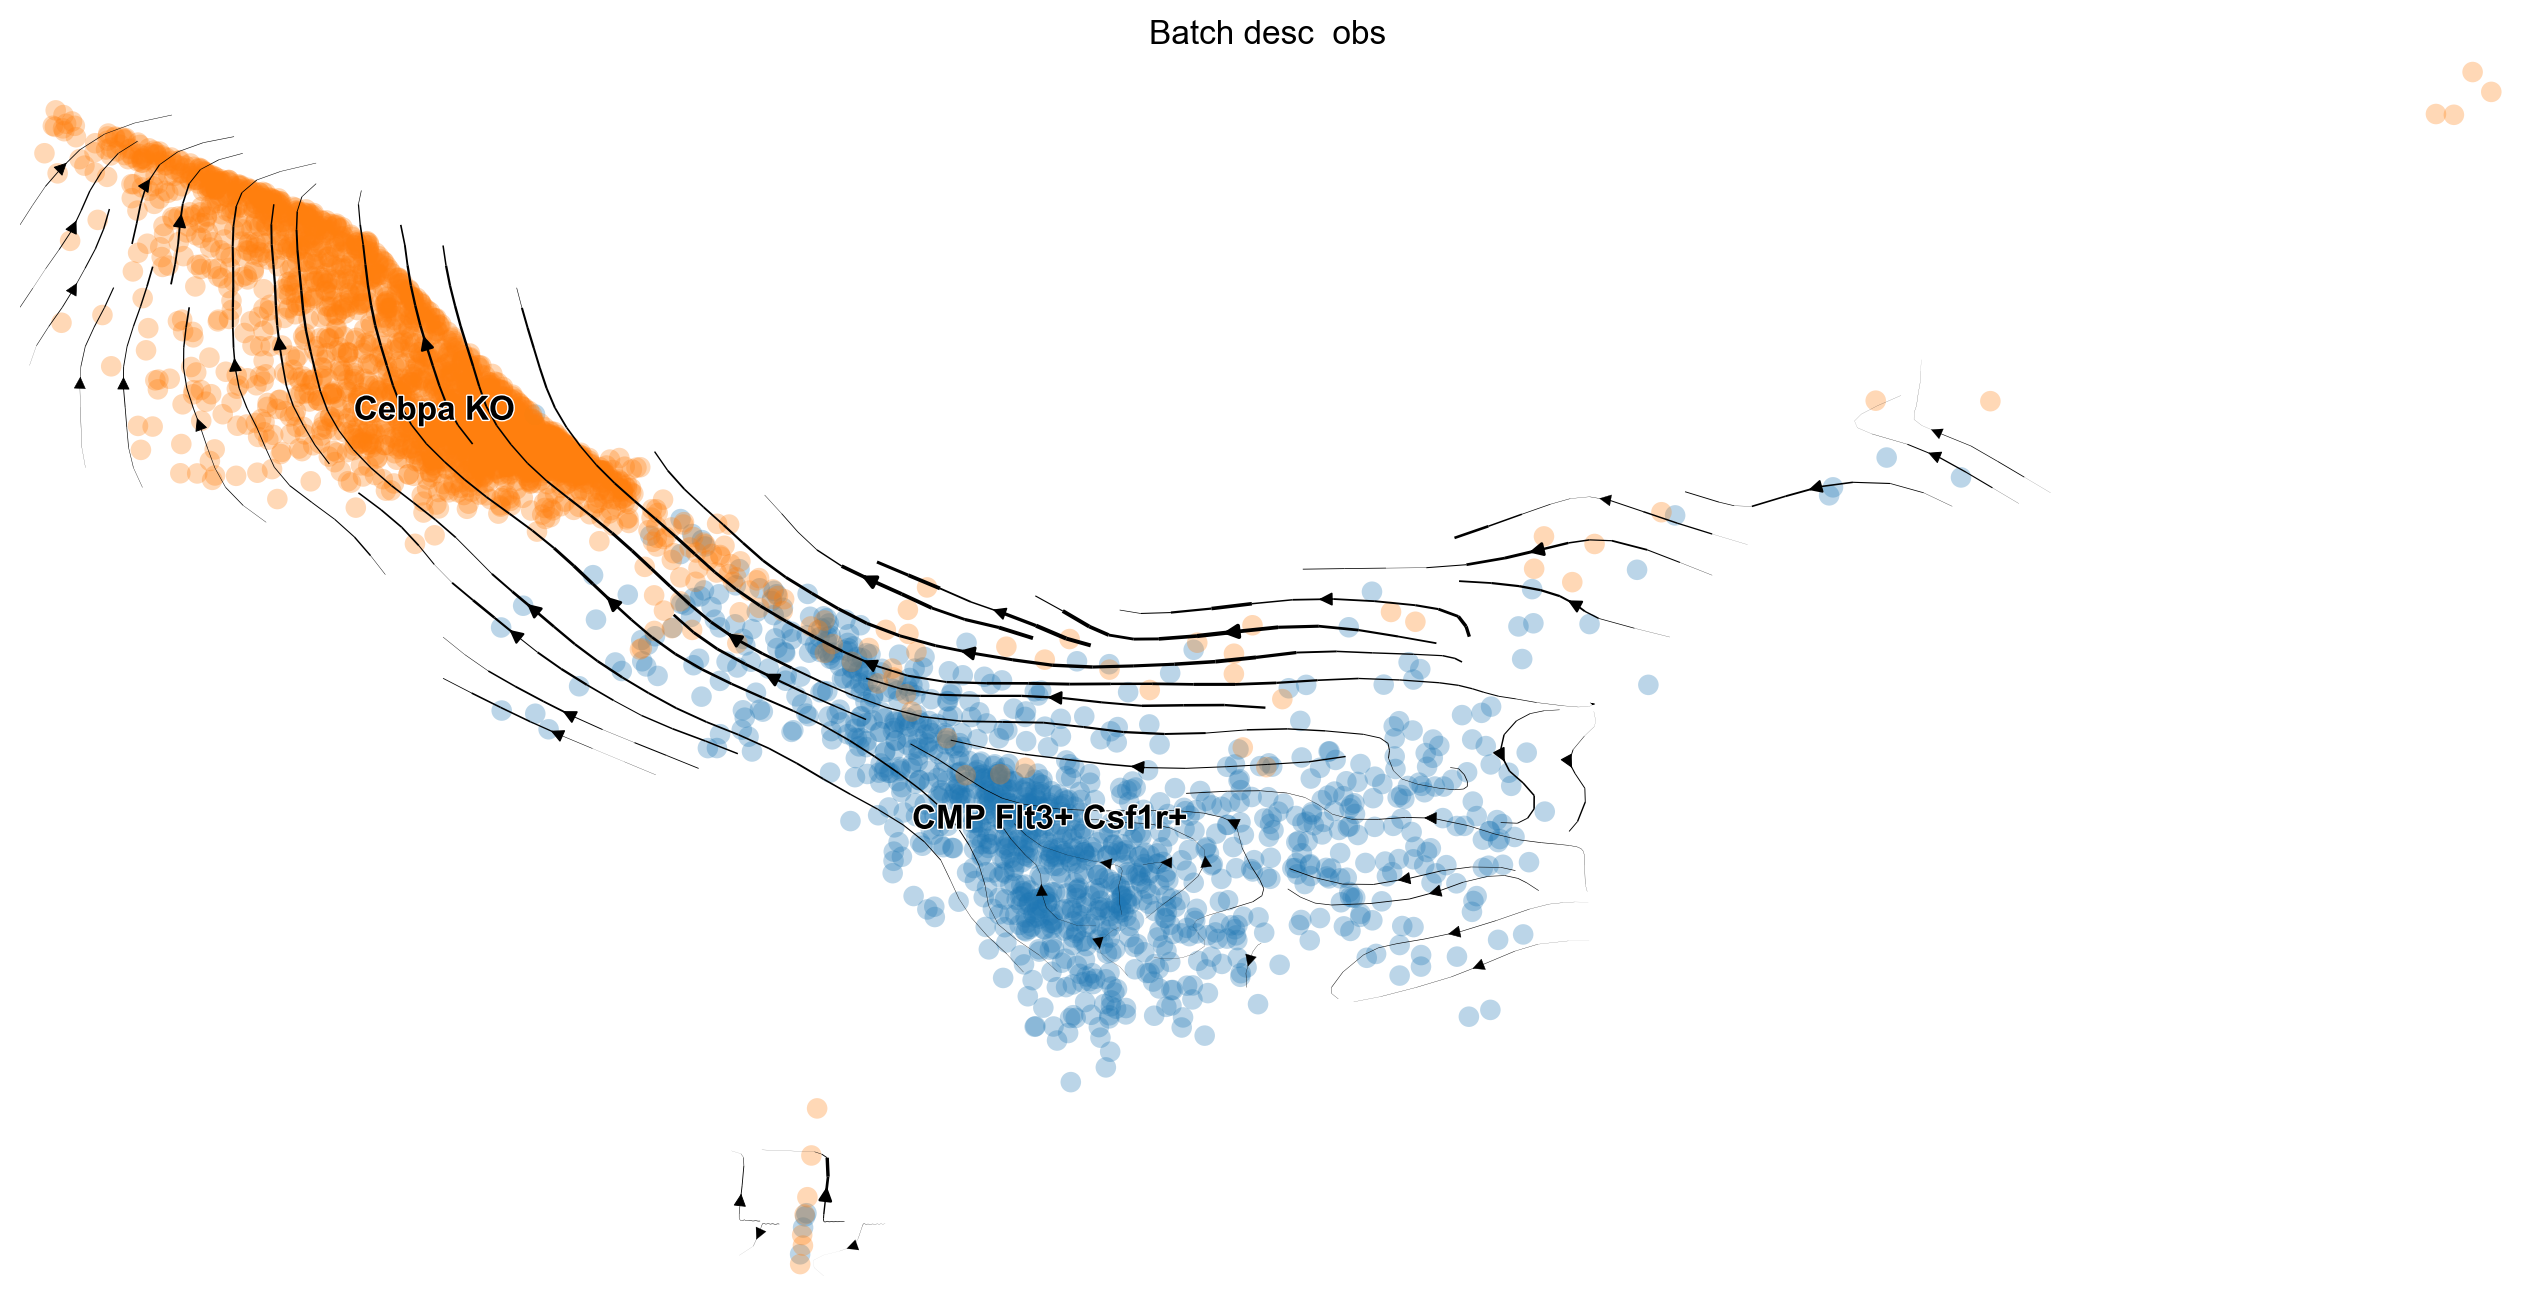

In [15]:
scv.pl.velocity_embedding_stream(cebpa_ko_adata, basis='umap', color="Batch_desc", layer="obs")

## Explore an unseen knockout: Spi1

In [19]:
available_ko_genes = [x.split("_")[1] for x in list(mycellpop.perturbseq.obs.index)]

In [20]:
len(available_ko_genes)

11258

In [25]:
"Spi1".upper() in available_ko_genes

True

In [26]:
mycellpop.intervene("Spi1")

In [27]:
with torch.no_grad():
    
    velocities = []
    
    for i in tqdm(range(cebpa_ko_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(cebpa_ko_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        
#         gene_expr = torch.cat((gene_expr, gene_expr, gene_expr), dim=2)
        velocity = mycellpop.get_derivatives(torch.cat((gene_expr, torch.zeros(batch_size, 50, 1)), dim=1))
        
        velocities.append(velocity[:, :-50])
        
velocities = torch.cat(velocities).cpu().numpy()[:, :, 0]
cebpa_ko_adata.layers["velocity"] = velocities
cebpa_ko_adata.layers["X"] = cebpa_ko_adata.X

100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:42<00:00, 21.03s/it]


In [28]:
scv.tl.velocity_graph(cebpa_ko_adata, xkey="X", gene_subset=highly_var_gene_list, n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/3456 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


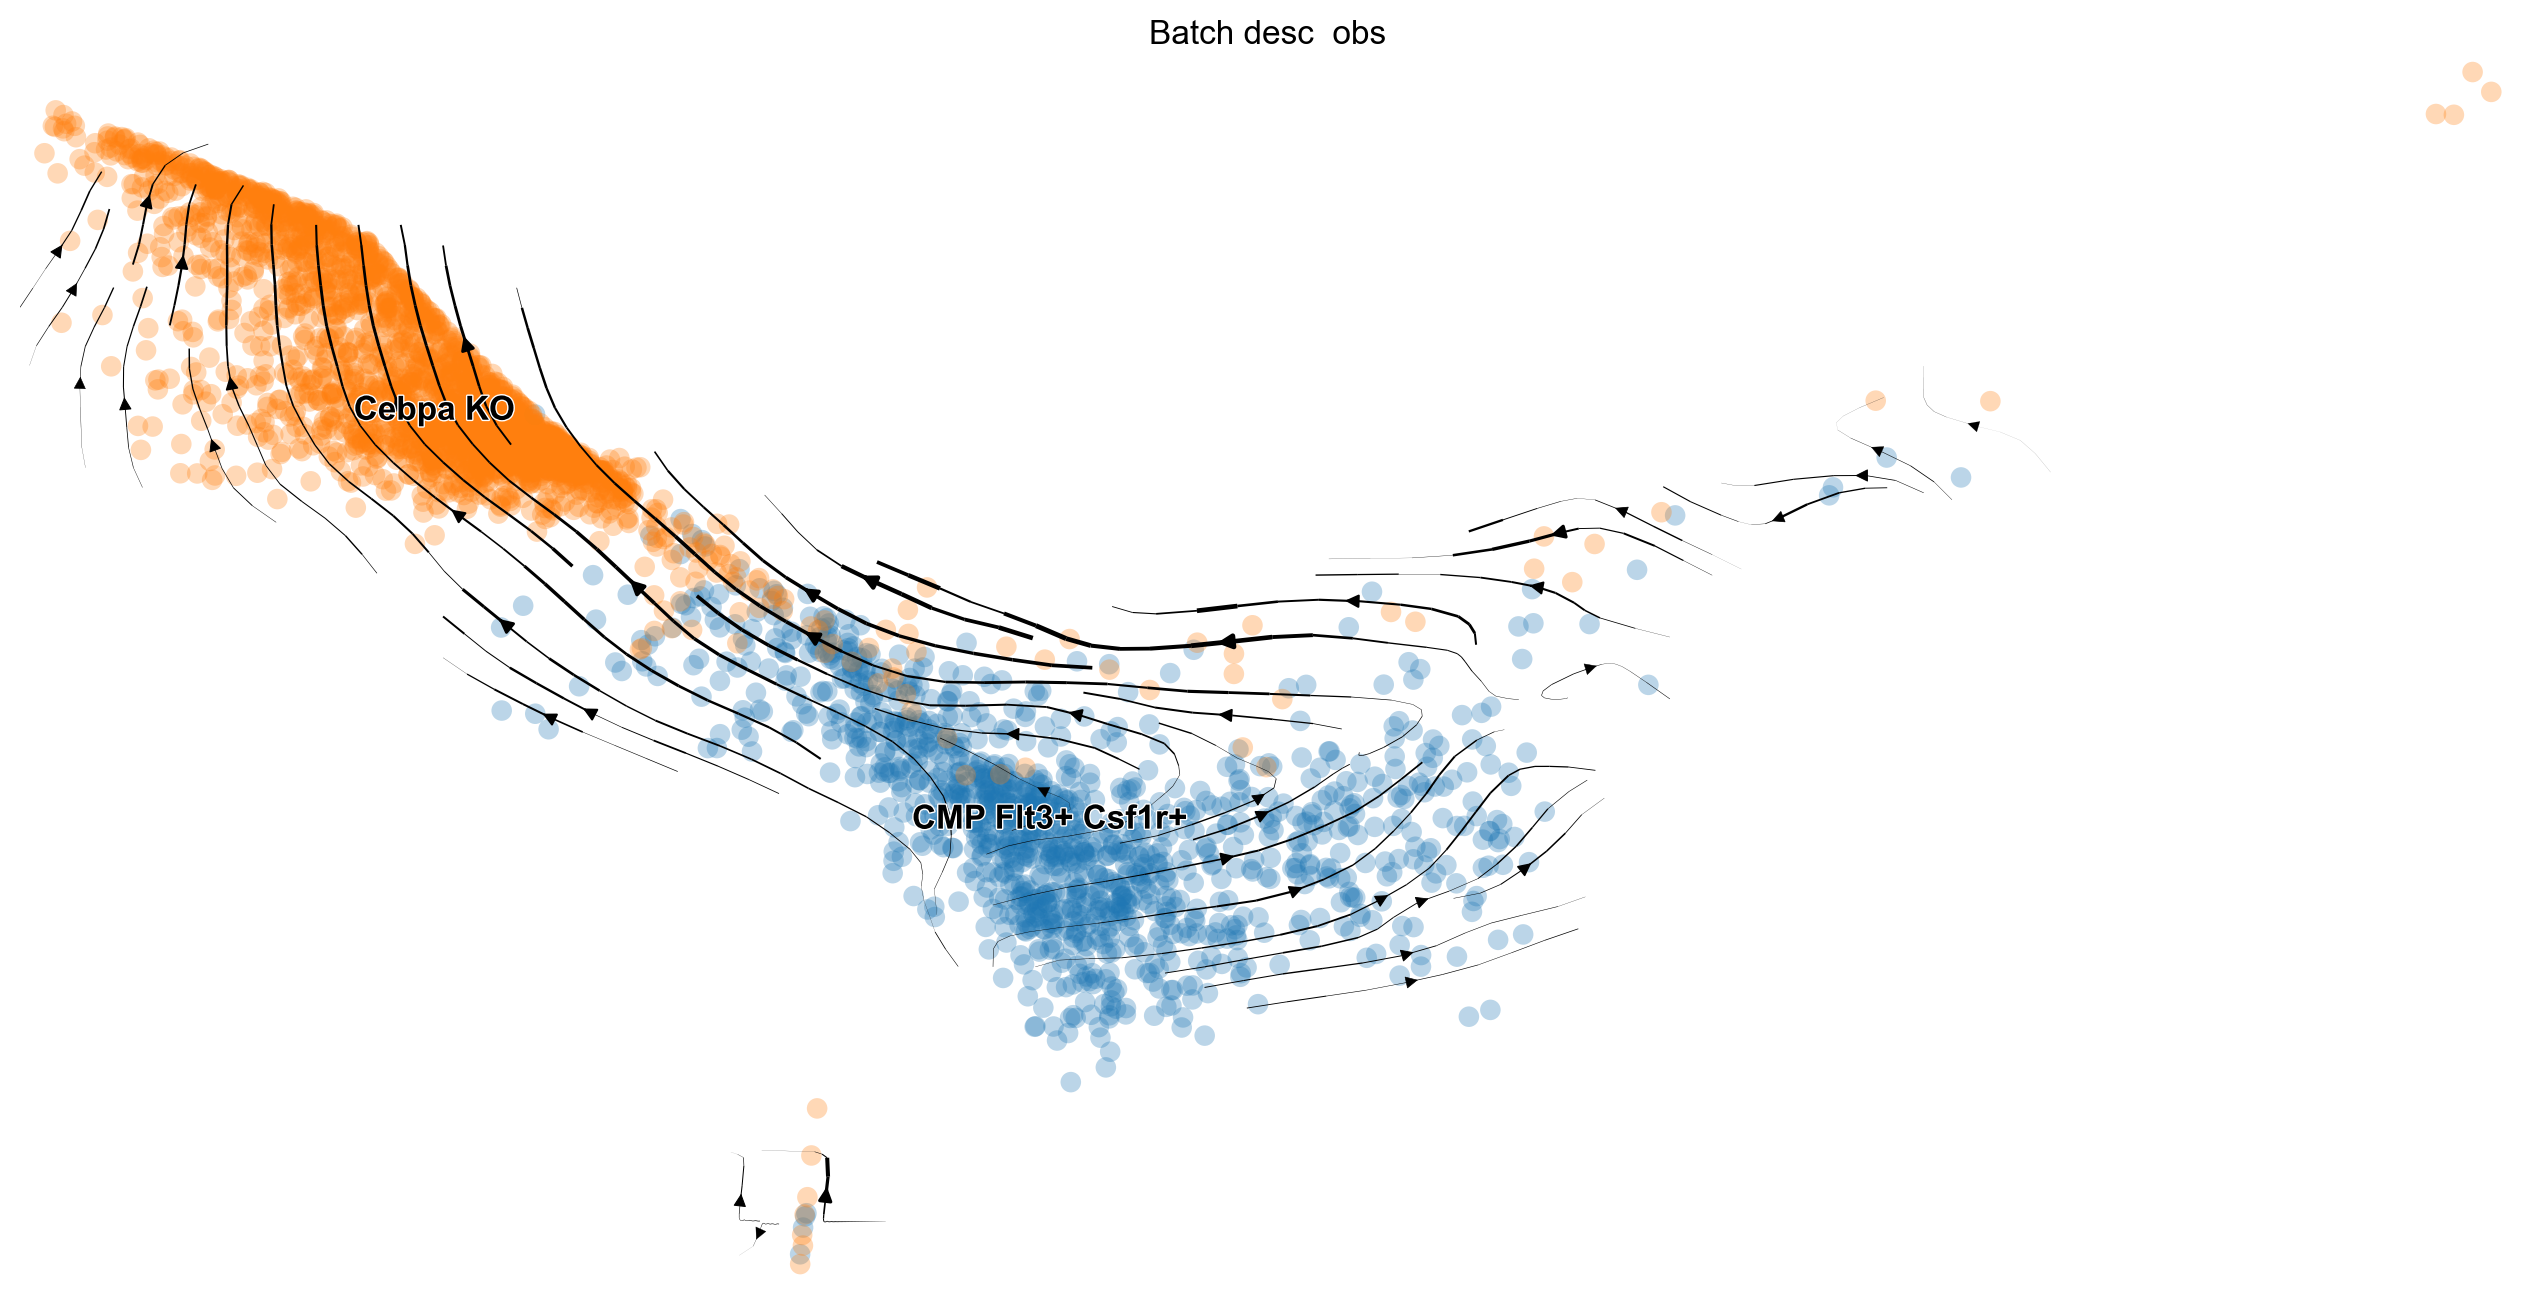

In [29]:
scv.pl.velocity_embedding_stream(cebpa_ko_adata, basis='umap', color="Batch_desc", layer="obs")